In [ ]:
# Cargar los datos y obtener el modelo
from common import *
mdl, produccion_vars, products = create_model()
solve_model(mdl, produccion_vars, products)

Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 5700
* Total benefit=5700
Production of A: 50.0
Production of B: 80.0
Production of C: 0


In [ ]:
#***Added by JL - 2024 Mar 03th - Checking sensitivity analysis *****')

# Initialize lists to store the results

#prices = []
#quantities = []

#real_price_value = 0

#m = 0.01


In [ ]:
def get_prod_var_for(product_name):
    prod_var = next((value for key, value in produccion_vars.items() if key[0] == product_name), None)
    print(f"prod_var: {prod_var}")
    if prod_var is None:
        raise ValueError(f"ERROR: no se encontró {product_name} en produccion_vars.")
    return prod_var

In [ ]:
# Aux: específica de Curva de oferta
# Perform sensitivity analysis of the objective
# Devuelve el lower y upper del rango actual para el coeficiente del funcional
# de la variable prod_var.
def perform_sensitivity_analysis(mdl, prod_name):
    lp = LinearRelaxer.make_relaxed_model(mdl)
    lp.solve()
    cpx = lp.get_engine().get_cplex()
    
    prod_var=get_prod_var_for(prod_name)

    idx=prod_var.index
    ranges = cpx.solution.sensitivity.objective()
    print("[debug] lower, upper:", ranges[idx])

    return ranges[idx]


In [ ]:
# Solves the model for a given price por a product
# price: price to consider
# prod_name: product name ("A", "B", "C")
# prod_number: product number considering their position in the objective (1 = "A", 2 = "B", 3 = "C", ...)
# Al prod_name le pone el price, y resuelve.
def solve_model_for_price(prod_name, price, mdl, products, produccion_vars):

    # Función objetivo
    # Toma los coeficientes de los datos excepto por el de la variable prod_name para la cual considera el coeficiente 'price'
    total_benefit = mdl.sum(produccion_vars[p] * (p[1] if p[0] != prod_name else price) for p in products)
    mdl.maximize(total_benefit)

    solution = mdl.solve()
    if solution is not None:
        print("* Production model solved with objective: {:g}".format(solution.objective_value))
        print("* Total benefit=%g" % solution.objective_value)
        for p in products:
            print("Production of {product}: {prod_var}".format(product=p[0], prod_var=produccion_vars[p].solution_value))

        return solution
    else:
        print("No solution found for price value: {0}".format(price))
        return None  # Return None to indicate that the model is infeasible at this point


In [ ]:
# Get quantity of the product in the solution
def get_y(prod_var):
    return prod_var.solution_value

In [ ]:
# aux: ver cantidad de parámetros.
# pre: se resolvió el modelo y existe solución.
#def iterate_over_price_en_construccion(constraint_nameX, constraint_nameY, mdl, products, produccion_vars, get_y_function): # aux: var mdl, 'm', y funciones.
def iterate_over_price_en_construccion(prod_name, prod_var, mdl, products, produccion_vars, get_y_function): # aux: var mdl, 'm', y funciones.
    PRICE_POSITION_IN_PRODUCTS = 1 # price position in products vector (0=name, 1=benefit, 2=max demand, 3=min demand)

    # Obtengo punto actual
    # Obs: Esto, a diferencia la iteración para otros gráficos (rhs) No requiere llamar a perform_sensitivity_analysis.
    # Buscamos el product_name en el array "products" para consultar en su primera posición su precio
    # (aux: products tiene tuplas, esto obtiene la tupla que tiene 'product_name' como primer valor)
    idx = next((i for i, prod in enumerate(products) if prod[0] == prod_name), None)
    current_price_value = products[idx][PRICE_POSITION_IN_PRODUCTS]
    current_quantity_value = get_y(prod_var)
    print(f"[DEBUG] QUANTITY DE CURRENT_PRICE: {current_quantity_value}")

    # Obtengo punto actual
    # Buscamos el product_name en el array "products" para consultar en su primera posición su precio
    # (aux: products tiene tuplas, esto obtiene la tupla que tiene 'product_name' como primer valor)
    idx = next((i for i, prod in enumerate(products) if prod[0] == prod_name), None)
    current_price_value = products[idx][PRICE_POSITION_IN_PRODUCTS]
    current_quantity_value = get_y(prod_var)
    print(f"[DEBUG] QUANTITY DE CURRENT_PRICE: {current_quantity_value}")
    
    #return current_price_value, prices, quantities
    #return iterate_internal(constraint_nameX, constraint_nameY, c, mdl, products, produccion_vars, get_y_function) # aux: var mdl, 'm', y funciones.
    return iterate_internal(prod_name, prod_var, current_price_value, current_quantity_value, mdl, products, produccion_vars, get_y_function, perform_sensitivity_analysis, solve_model_for_price) # aux: var mdl, 'm', y funciones.

#################################


In [ ]:
def iterate_over_price_for_var(product_name):
    # esto da, por ejemplo prod_var_or_min_dem_constraint=list(produccion_vars.values())[0] ## "A"
    prod_var = next((value for key, value in produccion_vars.items() if key[0] == product_name), None)
    print(f"prod_var: {prod_var}")
    if prod_var is None:
        raise ValueError(f"ERROR: no se encontró {product_name} en produccion_vars.")
    
    # Iteramos
    current_price_value, prices, quantities = iterate_over_price_en_construccion(product_name, prod_var, mdl, products, produccion_vars, get_y)
    
    # Le agregamos el punto de x=0 al inicio, porque la función que itera solo contempla números no negativos    
    price = 0     
    _ = solve_model_for_price(product_name, price, mdl, products, produccion_vars)
    quantity = get_y(prod_var)
    x_values = [price] + prices
    y_values = [quantity] + quantities

    return current_price_value, x_values, y_values


In [ ]:
product_name = "A"
current_price_value, prices, quantities = iterate_over_price_for_var(product_name)

prod_var: produccion_A_50_100_0
[DEBUG] QUANTITY DE CURRENT_PRICE: 50.0
[DEBUG] QUANTITY DE CURRENT_PRICE: 50.0
prod_var: produccion_A_50_100_0
[debug] lower, upper: (29.999999999999993, 1e+20)
[debug] (lower, upper): (29.999999999999993, 1e+20)
[debug] Viendo para rhs: 29.98999999999999
* Production model solved with objective: 4700
* Total benefit=4700
Production of A: 0
Production of B: 80.0
Production of C: 50.0
[debug al append] rhs: 29.98999999999999
prod_var: produccion_A_50_100_0
[debug] lower, upper: (-1e+20, 30.0)
[debug] sensitivity (-1e+20, 30.0)
[debug] Viendo para rhs: 1e+20
* Production model solved with objective: 4700
* Total benefit=4700
Production of A: 0
Production of B: 80.0
Production of C: 50.0


In [ ]:
print("prices:", prices)
print("quantities:", quantities) 
print("current:", current_price_value) 

# Round all values in the prices list to 2 decimal places    
#prices = [round(price, 2) for price in prices] #

prices: [0, 29.999999999999993, 29.999999999999993, 50]
quantities: [0, 0, 50.0, 50.0]
current: 50


In [ ]:
### Aux, probando
round(10.006, 2)
round(10.505, 2) 
#round(10.555, 2)

10.51

In [ ]:
def get_text_for_plot(xunit, yunit):
    xlabel='Precio {0}\n{1}'.format(product_name, xunit)
    ylabel='Cantidad\nProducida {0}\n{1}'.format(product_name, yunit)
    title='Curva de Oferta del Producto {}'.format(product_name)

    return {"xlabel": xlabel, "ylabel": ylabel, "title": title}

plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 0 0 29.999999999999993
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 0 29.999999999999993 29.999999999999993
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 50.0 29.999999999999993 50
[debug] current_x_value: 50


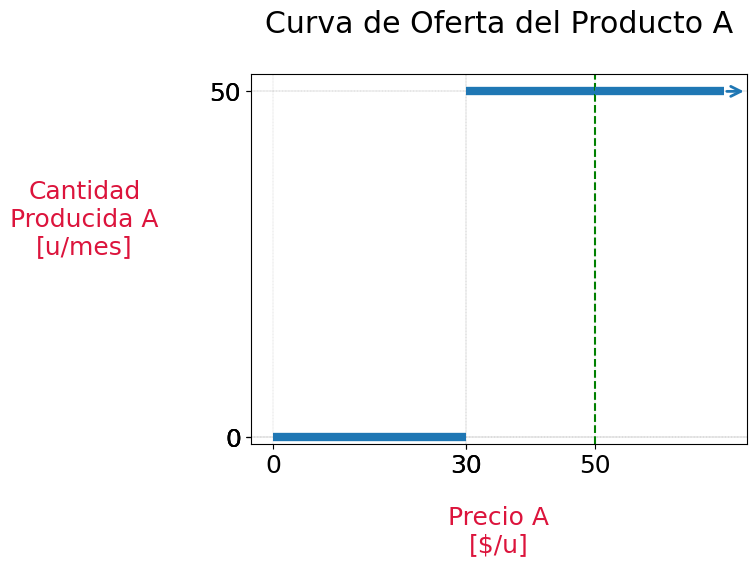

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Graficar
plot_text = get_text_for_plot("[$/u]", "[u/mes]")
plot(prices, quantities, current_price_value, plot_text)